<a href="https://colab.research.google.com/github/joshtan0710/pytorch_basics/blob/main/RNN_from_scratch_in_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
url = 'https://download.pytorch.org/tutorial/data.zip'
data = requests.get(url)
with open("text.zip", "wb") as code:
    code.write(data.content)

In [ ]:
import zipfile 

zip_ref = zipfile.ZipFile('/content/text.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Japanese.txt', 'data/names/Irish.txt', 'data/names/Arabic.txt', 'data/names/Vietnamese.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Russian.txt', 'data/names/Korean.txt', 'data/names/Italian.txt', 'data/names/Spanish.txt', 'data/names/Chinese.txt', 'data/names/English.txt', 'data/names/German.txt', 'data/names/French.txt', 'data/names/Polish.txt', 'data/names/Dutch.txt', 'data/names/Czech.txt', 'data/names/Greek.txt']
Slusarski


In [ ]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [ ]:
# Creating the model architecture

import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [ ]:
# Setting Hyperparams

criterion = nn.NLLLoss()
learning_rate = 0.003
optimizer = torch.optim.SGD(rnn.parameters(), lr = learning_rate)

In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i]

In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Polish / line = Poplawski
category = Polish / line = Zdunowski
category = Vietnamese / line = Luu
category = German / line = Schroeter
category = Scottish / line = Ross
category = Spanish / line = Sanchez
category = Polish / line = Janowski
category = Greek / line = Geracimos
category = Russian / line = Kachkaev
category = Irish / line = O'Boyle


In [ ]:
# training loop

def train(input_tensor,category_tensor):
  hidden = rnn.initHidden()

  for i in range(len(input_tensor)):
    output, hidden = rnn(input_tensor[i], hidden)

  loss = criterion(output, category_tensor)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return output, loss.item()



In [ ]:
current_loss = 0 
all_losses = []
plot_steps, print_steps = 1000,5000
n_iters = 100000

for i in range(1,n_iters+1):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output, loss = train(line_tensor, category_tensor)
  
  current_loss += loss

  if (i) % plot_steps == 0:
    all_losses.append(current_loss/plot_steps)
    current_loss = 0
  
  if i % print_steps == 0:
    guess = categoryFromOutput(output)

    # new if else syntax
    correct = "CORRECT" if guess == category else f"WRONG ({category})"
    print(f'Epoch {i}: {loss:.4f} {line} / {guess} {correct}')




Epoch 5000: 0.6839 Close / Greek CORRECT
Epoch 10000: 2.6250 Calligaris / Greek WRONG (Italian)
Epoch 15000: 2.8119 Muir / Chinese WRONG (Scottish)
Epoch 20000: 0.0981 Donndubhan / Irish CORRECT
Epoch 25000: 5.5855 Castillion / Russian WRONG (Spanish)
Epoch 30000: 0.1414 Mochan / Irish CORRECT
Epoch 35000: 3.2788 King / Chinese WRONG (Scottish)
Epoch 40000: 0.8284 Rinn / Irish CORRECT
Epoch 45000: 2.2518 Tsang / Korean WRONG (Chinese)
Epoch 50000: 0.0765 Malouf / Arabic CORRECT
Epoch 55000: 0.1003 Voltolini / Italian CORRECT
Epoch 60000: 3.0699 Unterbrink / Polish WRONG (German)
Epoch 65000: 1.2948 Shi / Korean WRONG (Chinese)
Epoch 70000: 1.0786 Holman / English CORRECT
Epoch 75000: 0.5048 Fakhoury / Arabic CORRECT
Epoch 80000: 0.1855 Strilakos / Greek CORRECT
Epoch 85000: 1.4649 Giese / French WRONG (German)
Epoch 90000: 0.0300 Warszawski / Polish CORRECT
Epoch 95000: 2.3622 Huie / Scottish WRONG (Chinese)
Epoch 100000: 0.6231 Hao / Chinese CORRECT


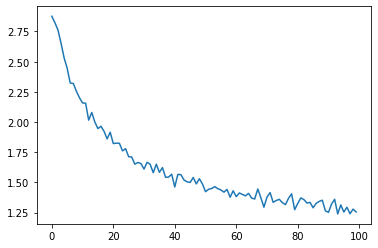

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [ ]:
# Running on User Input 

def predict(input_line, n_predictions = 2):
  print(f"\n >{input_line}")
  with torch.no_grad():
    input_tensor= lineToTensor(input_line)
    hidden = rnn.initHidden()

    for i in range(len(input_tensor)):
      output, hidden = rnn(input_tensor[i], hidden)

    guess = categoryFromOutput(output)
    print(guess)


In [25]:
predict('Xiao Cai')


 >Xiao Cai
Japanese
